# ==================== Calcula Resultado Anual ====================

In [1]:
from pandas import Series
import pandas as pd
from datetime import date
from IPython.display import display, Markdown
pd.__version__

'1.3.4'

In [2]:
import matplotlib as mat
mat.__version__

'3.4.3'

In [3]:
import time
time.asctime( time.localtime(time.time()) )

'Thu Feb 22 13:57:31 2024'

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)

In [6]:
# Setando definição de cores
def color_negative_red(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [7]:
import subprocess
p = subprocess.call(["powershell.exe", "copy 'Gerenciador de Ações.v6.xlsx' tempfile.xlsx"])

In [8]:
# Leitura de planilha Excel
ws = pd.read_excel('tempfile.xlsx', sheet_name="CÁLCULOS (3)", header=None)
# dt_acerto = ws[8][12]
dt_acerto = ws[8][12][19:29]
pc_liq_acerto = str(round(ws[5][13] * 100, 2)).replace('.', ',')
vr_liq_acerto = str(round(ws[5][12], 2)).replace('.', ',')
qt_acoes_acerto = str(ws[3][9])
vr_acao_acerto = ws[3][10]

In [9]:
import os
os.remove('tempfile.xlsx')

In [10]:
# Setando variáveis

ano = 2024

valor_acerto = 0
arquivo_csv = 'arquivos/relatorioOperacoes' + str(ano) + '.csv'
# Data, Porcentagem, Resultado, 
matrix_acerto = [['01/07/2020', '-20,79', '0,00', '0', 0],
                 ['01/09/2020', '2,66', '0,00', '0', 0],
                 ['02/02/2021', '-1,84', '0,00', '0', 0],
                 ['17/06/2021', '1,75', '0,00', '0', 0],
#                  ['25/07/2023', '1,18', '1027,32', '10800', 8.18]
                 [dt_acerto, pc_liq_acerto, vr_liq_acerto, qt_acoes_acerto, vr_acao_acerto]
                ]

In [11]:
# Usando o método read_csv
df = pd.read_csv(arquivo_csv, delimiter=";", encoding='ansi', decimal=",")

In [12]:
df.rename(columns={df.columns.values[0]: 'Data da Operação',
                   df.columns.values[1]: 'temp'}, inplace=True)
del df["temp"]

In [13]:
#Substitui NaN por "-"
df = df.fillna("-")

In [14]:
# Copia coluna "Lucro/Perda (R$)" para novo Dataframe dfTemp
dfTemp = df["Lucro/Perda (R$)"]
dfFinal = df

In [15]:
# Exclui coluna "Lucro/Perda (R$)" do Dataframe dfFinal
del dfFinal["Lucro/Perda (R$)"]

In [16]:
# Copia índices para exclusão do dfTemp
index = df[df['Ativo'] != '-'].index
# Exclui linhas nulas do dfTemp
dfTemp.drop(index, inplace=True)

In [17]:
# Reorganiza índice dfTemp
dfTemp.index = pd.Categorical(dfTemp.index).codes

In [18]:
# Copia índices para exclusão do dfFinal
index = df[df['Ativo'] == '-'].index
# Exclui linhas nulas do dfFinal
dfFinal.drop(index, inplace=True)

In [19]:
# Reorganiza índice dfFinal
dfFinal.index = pd.Categorical(dfFinal.index).codes

In [20]:
dfFinal[dfTemp.name] = dfTemp

In [21]:
# Adicionando linha com acerto
for x in range(len(matrix_acerto)):
    if ano == int(matrix_acerto[x][0][6:10]):
        linha_nova = [matrix_acerto[x][0],
                      'Acerto','Acerto','Acerto','Acerto',
                      str(matrix_acerto[x][3]),
                      str(matrix_acerto[x][4]),
                      0,
                      str(matrix_acerto[x][1]) + ' %',
                      str(matrix_acerto[x][2])]
        dfFinal.loc[len(dfFinal)] = linha_nova

In [22]:
# Conversão da coluna Data de Operação para tipo Data
dfFinal['Data da Operação'] = pd.to_datetime(dfFinal['Data da Operação'], format='%d/%m/%Y')

In [23]:
dfFinal = dfFinal.sort_values(['Data da Operação', 'Tipo Operação'], ascending=[True, False])

In [24]:
# Ajustando caracter de decimal e milhar em "Lucro/Perda (R$)", e conversão para float
dfFinal['Lucro/Perda (R$)'] = [x.replace('.','') for x in dfFinal[dfFinal.columns.values[9]]]
dfFinal['Lucro/Perda (R$)'] = [x.replace(',','.') for x in dfFinal[dfFinal.columns.values[9]]]
dfFinal['Lucro/Perda (R$)'] = dfFinal['Lucro/Perda (R$)'].astype(float)

In [25]:
# Removendo sinal de % para cálculos, e conversão para float
dfFinal['%'] = [x.replace(' %','') for x in dfFinal[dfFinal.columns.values[8]]]
dfFinal['%'] = [x.replace(',','.') for x in dfFinal[dfFinal.columns.values[8]]]
dfFinal['%'] = dfFinal['%'].astype(float)

In [26]:
del dfFinal['Característica']
del dfFinal['Corretora']

In [27]:
dfFinal['Qtde'] = dfFinal['Qtde'].astype(str)
dfFinal['Qtde'] = [x.replace('.','') for x in dfFinal['Qtde']]
dfFinal['Qtde'] = dfFinal['Qtde'].astype(int)

In [28]:
dfFinal.iloc[-1].index

Index(['Data da Operação', 'Tipo Operação', 'Ativo', 'Qtde', 'Preço (R$)',
       'Custo Médio (R$)', '%', 'Lucro/Perda (R$)'],
      dtype='object')

In [29]:
# Excluir linha de acerto da planilha caso o valor já esteja lançado.
if dfFinal.iloc[-1]['Lucro/Perda (R$)'] == dfFinal.iloc[-2]['Lucro/Perda (R$)']:
    dfFinal=dfFinal.drop(dfFinal.index[-1])

In [30]:
dfFinal['Preço (R$)'] = dfFinal['Preço (R$)'].astype(float)

In [31]:
# Calcula vr_compra
vr_compra_bruto = dfFinal['Qtde'] * dfFinal['Preço (R$)']

In [32]:
emolumentos = 325 / 1000000
corretagem = 49 / 10
vr_compra = vr_compra_bruto + corretagem + (vr_compra_bruto * emolumentos)

In [33]:
dfFinal['Valor Compra'] = vr_compra

In [34]:
# dfFinal.style.applymap(color_negative_red, subset=['%','Lucro/Perda (R$)'])

In [35]:
# Cria Dataframe com apenas Porcentagem e Lucro/Perda (R$)
df_sum = dfFinal[['%', 'Lucro/Perda (R$)']].copy()

In [36]:
df_sum.columns.values[0] = 'Porcentagem'

In [37]:
# Agrupa por mês totalizando o lucro/Prejuízo
df_sum_lucro_perda = dfFinal.groupby(dfFinal['Data da Operação']
                                     .dt.strftime('%B'))['Lucro/Perda (R$)'].sum()

In [38]:
# Agrupa por mês totalizando a Porcentagem
df_sum_porcentagem = dfFinal.groupby(dfFinal['Data da Operação']
                                     .dt.strftime('%B'))['%'].sum()

In [39]:
dfFinal_teste = dfFinal.groupby(['Data da Operação', 'Tipo Operação']).sum(['Lucro/Perda (R$)', 'Valor Compra'])
dfFinal_teste.reset_index(drop=False, inplace=True)

In [40]:
# del dfFinal_teste['Preço (R$)']
del dfFinal_teste['%']
dfFinal_teste['%'] = (dfFinal_teste['Lucro/Perda (R$)'] * 100) / dfFinal_teste['Valor Compra']

In [41]:
dfFinal_teste['Data da Operação'] = pd.to_datetime(dfFinal_teste['Data da Operação'], format='%d/%m/%Y')
df_sum_porcentagem_teste = dfFinal_teste.groupby(dfFinal_teste['Data da Operação']
                                     .dt.strftime('%B'))['%'].sum()

In [42]:
# df_sum_porcentagem_teste

In [43]:
# df_sum_porcentagem.style.applymap(color_elements)

In [44]:
array_meses = [4,8,12,2,1,7,6,3,5,11,10,9]
meses = []
if date.today().year == ano:
    for x in array_meses:
        if x <= date.today().month:
            meses.append(x)
else:
    meses = array_meses

In [45]:
# corrige lista de meses se mês atual não tiver operações
if len(meses) > len(df_sum_lucro_perda):
    meses.remove(max(meses))

In [46]:
# Cria DataFrame
df_tot_mes = pd.DataFrame({'cd_mes':meses
                         ,'Mês':df_sum_lucro_perda.index.values
                         ,'Lucro/Perda (R$)':df_sum_lucro_perda
                         ,'Porcentagem':df_sum_porcentagem})

In [47]:
df_tot_mes = df_tot_mes.set_index('cd_mes')

In [48]:
df_tot_mes.sort_index(inplace=True)

In [49]:
# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

In [50]:
# Calculando total do ano
resultado = round(df_sum['Lucro/Perda (R$)'].sum(), 2)
porcentagem = round(df_sum['Porcentagem'].sum(), 2)
resultado_txt = 'Lucro: ' if resultado >= 0 else 'Prejuízo...: '
porcentagem_txt = '> Porcentagem: '

# Total no Ano

In [51]:
Markdown(f'{porcentagem_txt}**{porcentagem}%**<br>{resultado_txt}**R${resultado}**')

> Porcentagem: **23.83%**<br>Lucro: **R$11076.96**

## Resultado Mensal

In [52]:
# df_tot_mes.style.applymap(color_negative_red, subset=['Lucro/Perda (R$)','Porcentagem'])
df_tot_mes

,Mês,Lucro/Perda (R$),Porcentagem
cd_mes,,,
1,January,634.83,2.91
2,February,"10,442.13",20.92


In [53]:
dfFinal['Qtde'] = dfFinal.loc[:, 'Qtde'].astype(int).map('{:,}'.format)
dfFinal

,Data da Operação,Tipo Operação,Ativo,Qtde,Preço (R$),Custo Médio (R$),%,Lucro/Perda (R$),Valor Compra
0,2024-01-03,Compra,BHIA3,"5,500",10.96,0.00,0.00,0.00,"60,304.49"
1,2024-01-04,Venda,BHIA3,"5,500",10.40,10.96,-5.07,"-3,060.26","57,223.49"
2,2024-01-08,Compra,RCSL3,"20,400",2.94,0.00,0.00,0.00,"60,000.39"
4,2024-01-09,Venda,RCSL3,"20,400",3.02,2.94,2.99,"1,799.46","61,632.92"
3,2024-01-09,Compra,CVCB3,"17,300",3.40,0.00,0.00,0.00,"58,844.02"
5,2024-01-10,Venda,CVCB3,"17,300",3.33,3.40,-1.82,"-1,072.98","57,632.62"
6,2024-01-10,Compra,RCSL3,"19,000",3.03,0.00,0.00,0.00,"57,593.61"
8,2024-01-11,Venda,RCSL3,"19,000",3.12,3.03,3.23,"1,864.88","59,304.17"
7,2024-01-11,Compra,GFSA3,"4,400",12.72,0.00,0.00,0.00,"55,991.09"
9,2024-01-12,Venda,GFSA3,"4,400",13.10,12.72,3.00,"1,681.90","57,663.63"


<IPython.core.display.Javascript object>


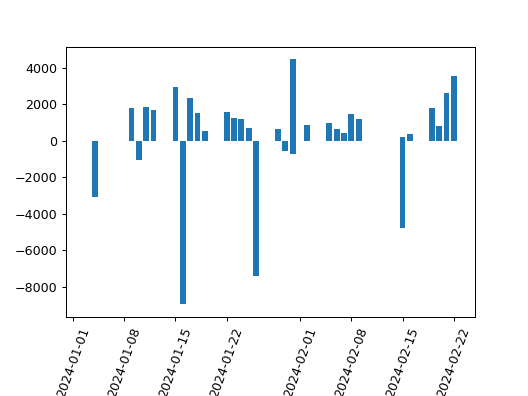

In [54]:
plt.xticks(rotation=70)
plt.subplots_adjust(bottom=0.20)
plt.bar(dfFinal[dfFinal.columns.values[0]], dfFinal[dfFinal.columns.values[7]])
plt.show()

### ======================================== TESTES ========================================

from subprocess import Popen
p = Popen("Executa.bat", cwd=r"C:\Users\esmer\Desktop\Alexandre\Projeto Git\StockManager")
stdout, stderr = p.communicate()

In [55]:
import pandas as pd

example = {'Team':['Australia', 'England', 'South Africa',
                   'Australia', 'England', 'India', 'India',
                        'South Africa', 'England', 'India'],
                          
           'Player':['Ricky Ponting', 'Joe Root', 'Hashim Amla',
                     'David Warner', 'Jos Buttler', 'Virat Kohli',
                     'Rohit Sharma', 'David Miller', 'Eoin Morgan',
                                                 'Dinesh Karthik'],
                                                   
          'Runs':[345, 336, 689, 490, 989, 672, 560, 455, 342, 376],
            
          'Salary':[34500, 33600, 68900, 49000, 98899,
                    67562, 56760, 45675, 34542, 31176] }
  
dfa = pd.DataFrame(example)

In [56]:
dfa

,Team,Player,Runs,Salary
0,Australia,Ricky Ponting,345,34500
1,England,Joe Root,336,33600
2,South Africa,Hashim Amla,689,68900
3,Australia,David Warner,490,49000
4,England,Jos Buttler,989,98899
5,India,Virat Kohli,672,67562
6,India,Rohit Sharma,560,56760
7,South Africa,David Miller,455,45675
8,England,Eoin Morgan,342,34542
9,India,Dinesh Karthik,376,31176


In [57]:
total_salary = dfa.groupby(['Team', 'Runs']).mean('Salary')

In [58]:
total_salary

Salary
Team         Runs          
Australia    345  34,500.00
             490  49,000.00
England      336  33,600.00
             342  34,542.00
             989  98,899.00
India        376  31,176.00
             560  56,760.00
             672  67,562.00
South Africa 455  45,675.00
             689  68,900.00

In [59]:
df_agg = dfFinal.loc[dfFinal['Data da Operação'] > '2021-11-01']
df_agg

,Data da Operação,Tipo Operação,Ativo,Qtde,Preço (R$),Custo Médio (R$),%,Lucro/Perda (R$),Valor Compra
0,2024-01-03,Compra,BHIA3,"5,500",10.96,0.00,0.00,0.00,"60,304.49"
1,2024-01-04,Venda,BHIA3,"5,500",10.40,10.96,-5.07,"-3,060.26","57,223.49"
2,2024-01-08,Compra,RCSL3,"20,400",2.94,0.00,0.00,0.00,"60,000.39"
4,2024-01-09,Venda,RCSL3,"20,400",3.02,2.94,2.99,"1,799.46","61,632.92"
3,2024-01-09,Compra,CVCB3,"17,300",3.40,0.00,0.00,0.00,"58,844.02"
5,2024-01-10,Venda,CVCB3,"17,300",3.33,3.40,-1.82,"-1,072.98","57,632.62"
6,2024-01-10,Compra,RCSL3,"19,000",3.03,0.00,0.00,0.00,"57,593.61"
8,2024-01-11,Venda,RCSL3,"19,000",3.12,3.03,3.23,"1,864.88","59,304.17"
7,2024-01-11,Compra,GFSA3,"4,400",12.72,0.00,0.00,0.00,"55,991.09"
9,2024-01-12,Venda,GFSA3,"4,400",13.10,12.72,3.00,"1,681.90","57,663.63"


In [60]:
df_agg.loc('2021-11-03':'2021-11-10', 'Data da Operação')

SyntaxError: invalid syntax (Temp/ipykernel_25900/860119016.py, line 1)

In [ ]:
df_agg.groupby(['Data da Operação', 'Tipo Operação', 'Ativo']) \
              .agg(teste1 = ('%', 'mean'), teste2 = ('Lucro/Perda (R$)', 'mean')) \
              .sort_values(['Data da Operação', 'Tipo Operação'], ascending=[True, False])

In [ ]:
df_teste = dfFinal.loc[dfFinal['Data da Operação'] > '2023-01-15'].groupby(['Data da Operação', 'Tipo Operação']).sum(['Lucro/Perda (R$)', 'Valor Compra'])

In [ ]:
del df_teste['Preço (R$)']
del df_teste['%']

In [ ]:
df_teste['%'] = (df_teste['Lucro/Perda (R$)'] * 100) / df_teste['Valor Compra']

In [ ]:
df_teste